# Phase Transitions: Principle Component Analysis and Machine Learning

__Outline of topics:__
1. PCA on raw spin configurations
    - Discrimination of phases using leading components
    - K-means clusterings
    - Autoencoder as an order parameter
    - PCA regression

__Idea:__
1. Given Monte Carlo data for the Ising model, use PCA to classify phases and characterize/predict the transition at inifinte volume.
    - The data is simply a design matrix with "features" interpretted as the lattice spins. Multiple samples are generated for a range of temperatures. Let there be $N_s$ configurations generated for an $L \times L$ lattice at a given temperature and we use a range of $t$ different temperatures. Then the design matrix has $N_s \times t$ rows and $L^2$ columns.
    - For small $L$, the system has little information of the transititon which occurs at infintie volume; thus, we expect to see better seperation of the configurations as the lattice size increases.
    - PCA is a linear transformation. So, quantities which are non-linear functions of the spins, such as the susepctibility, will not be explored by PCA.
        - __Extend work to an autoencoder!!!__
    - PCA is shown to correspond roughly to order parameters.

## Details of PCA

Given an $n \times m$ deisgn matrix $X$, we interpret the $m$ rows of $X$ as a random sample of $m$ observations containing $n$ features. In the case of lattice models, each row corresponds to a lattice spin configuration at asome given value of the external parameters. Each column corresponds the spin at a given site. Thankfully, Pandas can standardize matricies of this form (with or without dividing out the standard deviation) - taking $X$ as a dataframe, the line of code $X - X.mean()$ subtracts out the mean from each column of the matrix.

Taking $X$ to be feature-wise mean centered, PCA diagonalizes the covariance matrix Cov$(X)=X\,X^{\text{T}}$ and returns the ordered eigenvalues $\lambda_i$ (the variances of the principle compenents), the eigenvectors $e_i$, and the principle components $p_i=X \cdot e_i$. For instance, suppose we have a $5 \times 5$ lattice with 10,000 samples over 40 different temperatures thus giving a total of 400,000 samples (rows of $X$). Plotting the first two principle components in a data reduction fashion amounts to the 2D plot of $(p_1,p_2)$ which consists of 400,000 data points.

Importantly, since diagonalization is a linear transformation, the principle components are limited to _linear_ combinations of the features - it cannot explore non-linear combinations of features.

__Sources:__
1. Research articles on unsupervised machine learning applied to phase transitions: 
[Original](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.94.195105), 
[Follow-up](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.95.062122)
2. Methods of Multivariate Analysis by Alvin Rencher for details on principle component analysis
3. Autoencoders:
    - one of the original [papers](https://proceedings.neurips.cc/paper/1993/file/9e3cfc48eccf81a0d57663e129aef3cb-Paper.pdf)
    - in Keras [here](https://blog.keras.io/building-autoencoders-in-keras.html)

## Computation for LxL lattice

1. For each of the Nt temperatures in the range temperature_range:
    - Compute roughly N_measure uncorrelated measurements
    - which are separated by N_separation MC steps ( to ensure minimal correlation )
    - after N_burnin equlibriation steps
2. Perform PCA:
    - the deisgn matrix has rows of the lattice spins (linearized) and columns correspond to different configurations from possibly the same Monte Carlo run or a run at an adjacent temperature.
    - Plot the first two principle components, inspect quality of phase separation.
    - Many principle components will overlap on the plots, reducing the appareny number of data points.
3. Repeat process for lattices increasing size.

## Computation

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from time import time
from packages.Ising_functions import *
from packages.MCMC_functions import *
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
from joblib import Parallel, delayed
import multiprocessing
from functools import partial

num_cores = multiprocessing.cpu_count()

### Alternate form of Metropolis:
- We need to also trace the spin configirations along the Monte Carlo simulation.

In [3]:
def Metropolis_update(Latt, beta, N_burnin, N_measure, N_separation ):
    H = 0
    J = 1
    L = len(Latt)
    m = np.sum(Latt) # the magnetization
    
    e = 0
    for i in range(L):
        for j in range(L):
            # move through lattice and compute s_i * neighbors
            # this double counts bounds, so divide by 2 afterwards
            e += -J*Latt[i, j] * (Latt[(i+1)%L, j] + Latt[(i-1)%L, j]
                                  + Latt[i, (j+1)%L]+ Latt[i, (j-1)%L])
    e = e/2 - H*m
    
    # Perform the burnin stage, don't log the observables traces
    for s in range(N_burnin):
        # choose a random spin to flip - convince youself of the dE expression, do it by hand for a small lattice
        i, j = np.random.randint(0, L, 2)
        de = -2 * (-J) * Latt[i, j] * (Latt[(i+1)%L, j] + Latt[(i-1)%L, j]
                                            + Latt[i, (j+1)%L]+ Latt[i, (j-1)%L])
        de = de + 2*H*Latt[i,j]

        if np.random.rand() < np.exp(-beta*de):
            Latt[i,j] *= -1 # flip the spin if random # < exp(-\beta de)
            e += de
            m += 2*Latt[i,j]
    
    trace = np.zeros((N_measure,2)) # trace of energy and magnetization
    trace_Latt = []
    
    # Perform the measurement stage, log observables only every N_separation steps to obtain N_measure samples
    for s in range(N_measure):
        for sep in range(N_separation):
            # choose a random spin to flip - convince youself of the dE expression, do it by hand for a small lattice
            i, j = np.random.randint(0, L, 2)
            de = -2 * (-J) * Latt[i, j] * (Latt[(i+1)%L, j] + Latt[(i-1)%L, j]
                                                + Latt[i, (j+1)%L]+ Latt[i, (j-1)%L])
            de = de + 2*H*Latt[i,j]

            if np.random.rand() < np.exp(-beta*de):
                Latt[i,j] *= -1 # flip the spin if random # < exp(-\beta de)
                e += de
                m += 2*Latt[i,j]

        trace[s] = [m,e]
        trace_Latt.append(Latt.copy())
        ## If appending just Latt, the list will contain only "Latt" which is updated every step!!!
    
    return trace, trace_Latt

### Parallelized Monte Carlo Computation

In [41]:
L = 40

N_sites = L**2
N_burnin = 100*N_sites
N_measure = 10**2
N_separation = 50*N_sites

Nt = num_cores*5
temperature_range = np.linspace(2, 2.8, Nt)
t_list = []

for t in temperature_range:
    for n in range(N_measure):
        t_list.append(t)
t_list = np.array(t_list).reshape((-1,1))

In [42]:
t0 = time()

innerm_ = partial(Metropolis_update,  N_burnin = N_burnin, N_measure = N_measure, N_separation = N_separation )
output = Parallel(n_jobs = num_cores)(delayed(innerm_)(hotstart(L), 1/t) for t in temperature_range)

traces = np.array([out[0] for out in output]).reshape((Nt*N_measure, 2))
traces_Latt = np.array([out[1] for out in output]).reshape((Nt*N_measure, N_sites))
#Design_Matrix = np.reshape(traces_Latt, (Nt*N_measure, N_sites))

cols = ["Temperature", "Magnetization", "Energy"] + [f"spin {i+1}" for i in range(N_sites)]
mc_data = pd.DataFrame(np.concatenate((t_list, traces, traces_Latt), axis=1), columns=cols)

mc_data.to_csv('PCAproj/data/MC_'+ 
               f'L={L}_Nb={N_burnin//N_sites}sweeps_Nm={N_measure}__Ns={N_separation//N_sites}sweeps.csv',
               index=False)

t1 = time()
m, s = divmod(t1-t0, 60)
h, m = divmod(m, 60)
f"Computation time = {h} hours, {m} minutes, {s} seconds"

'Computation time = 0.0 hours, 9.0 minutes, 43.272151947021484 seconds'

## Principle component computation and plot

In [43]:
# mc_data = pd.read_csv('PCAproj/data/MC_'+ 
#                f'L={L}_Nb={N_burnin//N_sites}sweeps_Nm={N_measure}__Ns={N_separation//N_sites}sweeps.csv')

In [44]:
Design_Matrix = mc_data[[f"spin {i+1}" for i in range(N_sites)]]

scaler = StandardScaler(with_std=False)
scaler.fit(Design_Matrix)
Design_Matrix_scaled = pd.DataFrame(scaler.transform(Design_Matrix))

print(np.shape(Design_Matrix_scaled))

pca = PCA(n_components=2)
princ_comps = pca.fit_transform(Design_Matrix_scaled)

princ_df = pd.DataFrame(data = princ_comps, columns = ["principle component 1", "principle component 2"] )

princ_df = pd.concat([princ_df, pd.DataFrame(data = t_list, columns = ["temperature"])], axis = 1)

princ_df.to_csv('PCAproj/data/PCA_' + 
                f'L={L}_Nb={N_burnin//N_sites}sweeps_Nm={N_measure}__Ns={N_separation//N_sites}sweeps.csv',
               index=False)

(4000, 1600)


In [45]:
# princ_df = pd.read_csv('PCAproj_data/PCA_' +
#                        f'L={L}_Nb={N_burnin//N_sites}sweeps_Nm={N_measure}__Ns={N_separation//N_sites}sweeps.csv')

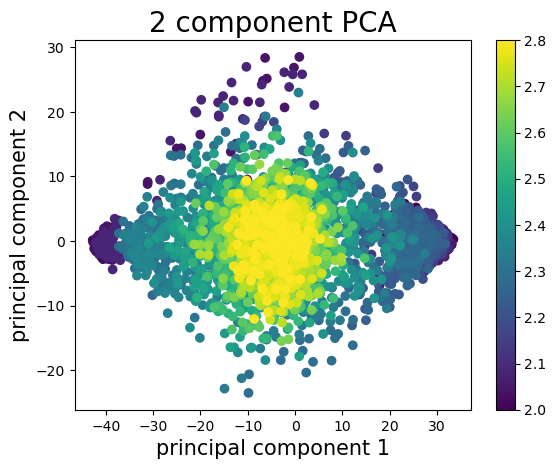

In [46]:
fig, ax = plt.subplots(1,1)
cm = plt.colormaps.get_cmap('RdYlBu')
ax.set_xlabel('principal component 1', fontsize = 15)
ax.set_ylabel('principal component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

sc = ax.scatter(princ_df.loc[:, "principle component 1"], princ_df.loc[:, "principle component 2"], 
                c = princ_df.loc[:, "temperature"])
plt.colorbar(sc)
plt.show()
fig.savefig('PCAproj/plots/p1p2' +
           f'L={L}_Nb={N_burnin//N_sites}sweeps_Nm={N_measure}__Ns={N_separation//N_sites}sweeps.png') 
plt.close(fig)    # close the figure window

## KMeans computation

In [47]:
from sklearn.cluster import KMeans

princ_df = pd.read_csv('PCAproj_data/PCA_' +
                       f'L={L}_Nb={N_burnin//N_sites}sweeps_Nm={N_measure}__Ns={N_separation//N_sites}sweeps.csv')
princ_array = np.array(princ_df)

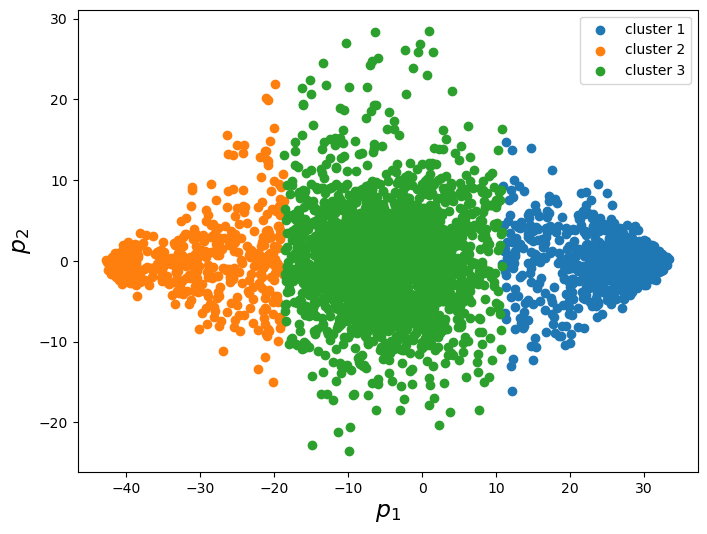

In [48]:
kmeans = KMeans(init="k-means++", n_clusters=3, n_init=4)
kmeans.fit(princ_array)

fig, ax = plt.subplots(figsize=(8, 6))

cluster0 = princ_array[kmeans.labels_ == 0]
cluster1 = princ_array[kmeans.labels_ == 1]
cluster2 = princ_array[kmeans.labels_ == 2]

ax.scatter(cluster0[:, 0], cluster0[:, 1], label='cluster 1')
ax.scatter(cluster1[:, 0], cluster1[:, 1], label='cluster 2')
ax.scatter(cluster2[:, 0], cluster2[:, 1], label='cluster 3')
ax.set_ylabel(r'$p_2$', fontsize=17)
ax.set_xlabel(r'$p_1$', fontsize=17)
ax.legend()
plt.show()